In [1]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-dataset/raw/main/dataset.zip
!unzip -qq dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   153    0   153    0     0    326      0 --:--:-- --:--:-- --:--:--   326
100 6958k  100 6958k    0     0  4917k      0  0:00:01  0:00:01 --:--:-- 25.0M


In [2]:
import os
import numpy as np
import keras

In [3]:
_rotation = 20 
_zoom = 0.5
_flip = True
_batch_size = 32
_random_state = 42
_input_shape = (150, 150, 1)
_dropout = 0.6
_alpha = 1e-5
_epochs = 10
_hidden_unit = 32
_kernel_size = 3
_trainable_layer = 'block5_conv1'

# Data preparation

In [4]:
from PIL import Image

def select_image(filename):
    _image = Image.open(filename)
    _image = _image.convert('RGB')
    _image = _image.resize((150,150))
    return np.asarray(_image)

In [5]:
def load_class(directory, label_class, images, labels):
    for filename in os.listdir(directory):
        _path = directory + filename
        images.append(_path)
        labels.append(label_class)
    return images, labels

In [6]:
def select_dataset(directory):
    _images = list()
    _labels = list()
    for subdir in os.listdir(directory):
        _path = directory + subdir + '/'
        if not os.path.isdir(_path):
            continue
        _images, _labels = load_class(_path, subdir, _images, _labels)
    return _images, _labels

In [7]:
_images, _labels = select_dataset('./data/')
print(len(_images), len(_labels))

5220 5220


In [8]:
from sklearn.preprocessing import LabelBinarizer

_labelBinarizer = LabelBinarizer()

In [9]:
from keras.utils import to_categorical

def normalize(images, labels):
    labels = np.array(labels)
    labels = _labelBinarizer.fit_transform(labels)
    labels = to_categorical(labels)
    return images, labels

_images, _labels = normalize(_images, _labels)

# Download models

In [13]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_BiGRU.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   167    0   167    0     0    479      0 --:--:-- --:--:-- --:--:--   479
100 24.2M  100 24.2M    0     0  6857k      0  0:00:03  0:00:03 --:--:-- 11.7M


In [14]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_BiLSTM.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   168    0   168    0     0    482      0 --:--:-- --:--:-- --:--:--   482
100 27.6M  100 27.6M    0     0  8797k      0  0:00:03  0:00:03 --:--:-- 16.6M


In [15]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_GRU.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   165  100   165    0     0    457      0 --:--:-- --:--:-- --:--:--   457
100 19.0M  100 19.0M    0     0  7282k      0  0:00:02  0:00:02 --:--:-- 17.0M


In [16]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_LSTM.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   166  100   166    0     0    475      0 --:--:-- --:--:-- --:--:--   474
100 20.7M  100 20.7M    0     0  4978k      0  0:00:04  0:00:04 --:--:-- 7825k


In [17]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_GRU_GRU.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   169    0   169    0     0    485      0 --:--:-- --:--:-- --:--:--   484
100 24.3M  100 24.3M    0     0  6696k      0  0:00:03  0:00:03 --:--:-- 11.2M


In [18]:
!curl -LO https://github.com/chsponciano/pocket-parkinson-classifier/raw/main/models/CRNN_LSTM_LSTM.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   171  100   171    0     0    502      0 --:--:-- --:--:-- --:--:--   501
100 27.8M  100 27.8M    0     0  8474k      0  0:00:03  0:00:03 --:--:-- 15.3M


# Testing the models

In [10]:
from IPython.display import HTML, display

def progress_bar(title, subtitle, hits, errors, value, max):
    return HTML("""
        <h3>{title}</h3>
        <p>{subtitle}</p>
        <p>Hits: {hits} - Errors: {errors}</p>
        <progress value='{value}' max='{max}', style='width: 90%'>{value}</progress>"""
    .format(title=title, subtitle=subtitle, hits=hits, errors=errors, value=value, max=max))

In [11]:
_models = ['CRNN_GRU', 'CRNN_GRU_GRU', 'CRNN_BiGRU', 'CRNN_LSTM', 'CRNN_LSTM_LSTM', 'CRNN_BiLSTM']

In [12]:
_results = {}

In [13]:
from keras.models import load_model

_size = len(_images)

for model_name in _models:
  _panel = display(progress_bar, display_id=True)
  _panel.update(progress_bar(model_name, f'Testing the model {model_name}', 0, 0, 0, _size))
  _results[model_name] = { 'hits': 0, 'errors': 0  }
  _model = load_model(f'/content/{model_name}.hdf5')

  for i in range(0, _size):
    _image = np.array([select_image(_images[i])]) / 255.0
    _predict = _model.predict(_image)[0]
    _predict = 0 if _predict[0] > _predict[1] else 1
    _results[model_name]['hits' if _labels[i][_predict] == 1.0 else 'errors'] += 1
    _panel.update(progress_bar(model_name, f'Testing the model {model_name}', _results[model_name]['hits'], _results[model_name]['errors'], i, _size))

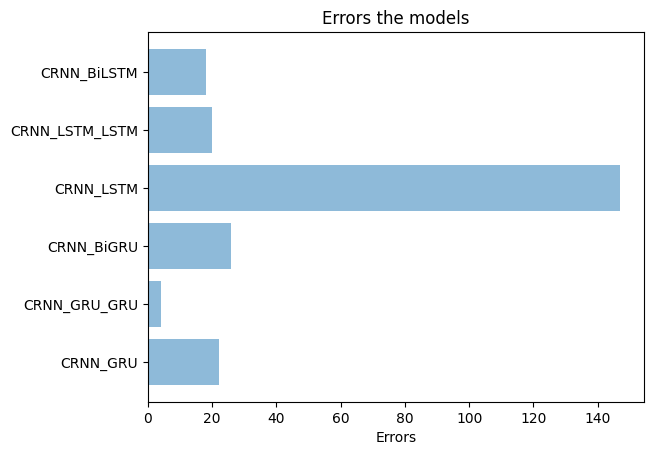

In [22]:
import matplotlib.pyplot as plt
plt.rcdefaults()

_y_pos = np.arange(len(_models))
plt.barh(_y_pos, [_results[m]['errors'] for m in _models], align='center', alpha=0.5)
plt.yticks(_y_pos, _models)
plt.xlabel('Errors')
plt.title('Errors the models')
plt.show()